In [1]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add

In [2]:
files_input_tr = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/input_*'))
files_target_tr = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/target_*'))
data_tr = CustomDataset(files_input_tr, files_target_tr)
dataset_tr = data_tr.get()
print("finish loading training dataset")

files_input_vl = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/validation_dataset/input_*'))
files_target_vl = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/validation_dataset/target_*'))
data_vl = CustomDataset(files_input_vl, files_target_vl)
dataset_vl = data_vl.get()
print("finish loading validation dataset")

finish loading training dataset
finish loading validation dataset


In [3]:
NUM_LAYERS = 5
HIDDEN_CHANNELS=128

In [4]:
BATCH_SIZE = 32
loader_tr = DataLoader(dataset_tr, batch_size=BATCH_SIZE, drop_last=True)
loader_vl = DataLoader(dataset_vl, batch_size=BATCH_SIZE, drop_last=True)

In [5]:
for vdata in loader_vl:
    break

In [6]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 4], edges=[117026, 4], senders=[117026], receivers=[117026], graph_globals=[32], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [16]:
from wmpgnn.model.gnn_model import EncodeProcessDecode

In [17]:
from wmpgnn.util.functions import weight_four_class, acc_four_class

In [18]:
weights=weight_four_class(loader_tr)

tensor([2.5158e-01, 1.7982e+02, 6.0619e+01, 3.2675e+02])


In [19]:
MLP_OUTPUT_SIZE=8
myModel=EncodeProcessDecode(mlp_output_size=MLP_OUTPUT_SIZE, edge_op=4, num_blocks=6)

myModel.cuda()

optimizer = torch.optim.Adam(myModel.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights)
pos_weight = torch.tensor([166.128])  

criterionBCE = nn.BCELoss(weight=pos_weight) 
pos_weight = torch.tensor([15.5])
criterionBCEnodes = nn.BCELoss(weight=pos_weight) 

criterion.to('cuda')
criterionBCE.cuda()
criterionBCEnodes.cuda()

BCELoss()

In [20]:
last_batch = len(loader_tr)

def train_one_epoch(epoch_index):
    
    running_loss = 0.
    last_loss = 0.
    acc_one_epoch = []
    for i, data in enumerate(loader_tr): 
        data['graph_globals'] = data['graph_globals'].unsqueeze(1)
        data.receivers = data.receivers - torch.min(data.receivers)
        data.senders = data.senders - torch.min(data.senders)
        data.edgepos = data.edgepos - torch.min(data.edgepos)
        optimizer.zero_grad()
        #print(data)
        data.to('cuda')
        #print("shape before ", data.y.shape)
        yBCE_start = 1.*(data.y[:,0]==0).unsqueeze(1)
        num_nodes=data.nodes.shape[0]
        out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
        node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
        ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
        label0 = data.y.argmax(dim=1)
        answers = torch.ones_like(data.edges).cuda()

        outputs = myModel(data, num_processing_steps=STEP_SIZE)

        data = outputs


        label= data.y.argmax(dim=1)
        num_nodes=data.nodes.shape[0]
        out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
        node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
        ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)


        loss = criterion(outputs.edges, label) 
        yBCE = 1.*(data.y[:,0]==0).unsqueeze(1)
        for block in myModel._blocks:
            loss += 0.2*criterionBCE(block._network.edge_weights, yBCE)
            loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes)
                

    
        loss.backward()


        acc_one_batch = acc_four_class(outputs.edges, label)
        acc_one_epoch.append(acc_one_batch)

        optimizer.step()

        running_loss += loss.item()
        if (i+1) == last_batch:
            last_loss = running_loss / last_batch # loss per batch
            print('  batch {} last_batch {} loss: {}'.format(i + 1, last_batch, last_loss))

            running_loss = 0.
    
        
    acc_one_epoch=torch.stack(acc_one_epoch)

    return last_loss, acc_one_epoch.nanmean(dim=0)

In [21]:
last_batch_vl = len(loader_vl)

def eval_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    acc_one_epoch = []
    
    for j, vdata in enumerate(loader_vl): 

        vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
        vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
        vdata.senders = vdata.senders - torch.min(vdata.senders)
        vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
        vdata.to('cuda')
        yBCE_start = 1.*(vdata.y[:,0]==0).unsqueeze(1)
        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
        
        label0 = vdata.y.argmax(dim=1)
        answers = torch.ones_like(vdata.edges).cuda()

        outputs = myModel(vdata, num_processing_steps=STEP_SIZE)

        vdata = outputs
        label= vdata.y.argmax(dim=1)

        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)

        loss = criterion(outputs.edges, label) 
        yBCE = 1.*(vdata.y[:,0]==0).unsqueeze(1)
        for block in myModel._blocks:
            loss += 0.2*criterionBCE(block._network.edge_weights, yBCE)
            loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes)

        #if myModel._blocks[3]._network.edge_prune:

        acc_one_batch = acc_four_class(outputs.edges, label)
        acc_one_epoch.append(acc_one_batch)
#         break
        # Gather data and report
        running_loss += loss.item()
        if (j+1) == last_batch_vl:
            last_loss = running_loss / last_batch_vl # loss per batch
            print(' validation: batch {} last_batch {} loss: {}'.format(j + 1, last_batch_vl, last_loss))
            running_loss = 0.
    
    acc_one_epoch=torch.stack(acc_one_epoch)

    return last_loss, acc_one_epoch.nanmean(dim=0)

In [22]:
STEP_SIZE = 2

lst_tr_loss = []
lst_vl_loss = []

lst_vl_acc = []
lst_tr_acc = []
start = time.time()

epoch_number = 0

EPOCHS = 30

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print("epoch no. ", (epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    myModel.train(True)
    tr_loss, tr_acc= train_one_epoch(epoch_number)
    lst_tr_loss.append(tr_loss)
    lst_tr_acc.append(tr_acc)
#     break
    # We don't need gradients on to do reporting
    myModel.train(False)
    vl_loss, vl_acc= eval_one_epoch(epoch_number)
    lst_vl_loss.append(vl_loss)
    lst_vl_acc.append(vl_acc)
    
    print(f'Train Loss: {tr_loss:03f}')
    
    epoch_number += 1
    

end = time.time()

epoch no.  1
  batch 1234 last_batch 1234 loss: 13.211484865779042
 validation: batch 290 last_batch 290 loss: 10.617620593103869
Train Loss: 13.211485
epoch no.  2


KeyboardInterrupt: 

In [ ]:
optimizer = torch.optim.Adam(myModel.parameters(), lr=0.0001)

epoch_number = 32

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print("epoch no. ", (epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    myModel.train(True)
    tr_loss, tr_acc= train_one_epoch(epoch_number)
    lst_tr_loss.append(tr_loss)
    lst_tr_acc.append(tr_acc)
#     break
    # We don't need gradients on to do reporting
    myModel.train(False)
    vl_loss, vl_acc= eval_one_epoch(epoch_number)
    lst_vl_loss.append(vl_loss)
    lst_vl_acc.append(vl_acc)
    
    print(f'Train Loss: {tr_loss:03f}')
    
    epoch_number += 1

In [23]:
class1_acc_vl=[]
class2_acc_vl=[]
class3_acc_vl=[]
class4_acc_vl=[]


for vl_acc in lst_vl_acc:
    class1_acc_vl.append(vl_acc[0])
    class2_acc_vl.append(vl_acc[1])
    class3_acc_vl.append(vl_acc[2])
    class4_acc_vl.append(vl_acc[3])

In [24]:
class1_acc_tr=[]
class2_acc_tr=[]
class3_acc_tr=[]
class4_acc_tr=[]


for tr_acc in lst_tr_acc:
    class1_acc_tr.append(tr_acc[0])
    class2_acc_tr.append(tr_acc[1])
    class3_acc_tr.append(tr_acc[2])
    class4_acc_tr.append(tr_acc[3])

In [28]:
lst_tr_loss

[13.211484865779042]

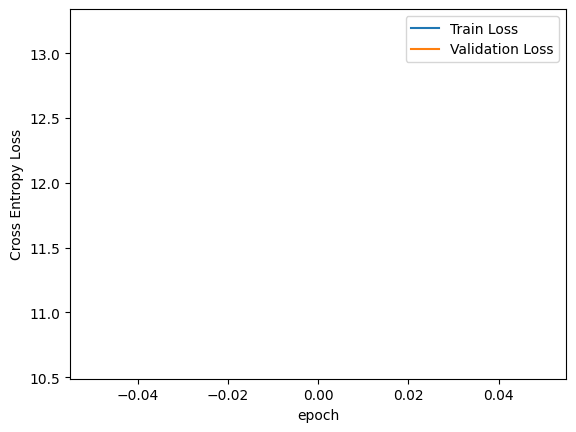

In [27]:
import matplotlib.pyplot as plt
import os
  

    
plt_numlayer = "{}{}".format("No. layers=", NUM_LAYERS)
plt_channel = "{}{}".format("hidden channels=", HIDDEN_CHANNELS)
plt_mlp = "{}{}".format("mlpout=", MLP_OUTPUT_SIZE)
plt_step = "{}{}".format("step=", STEP_SIZE)

plt_filename = "{}{}{}{}".format("L", NUM_LAYERS, "C", HIDDEN_CHANNELS)


plt.plot(lst_tr_loss, label="Train Loss")
plt.plot(lst_vl_loss, label="Validation Loss")

plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
#plt.ylabel('Focal Loss')


plt.legend()
plt.savefig("loss_new_4.png")
# plt.savefig("figures_Oct/"+file_batch+"/loss_"+plt_filename+"_2cores_norm"+".png")

plt.show()

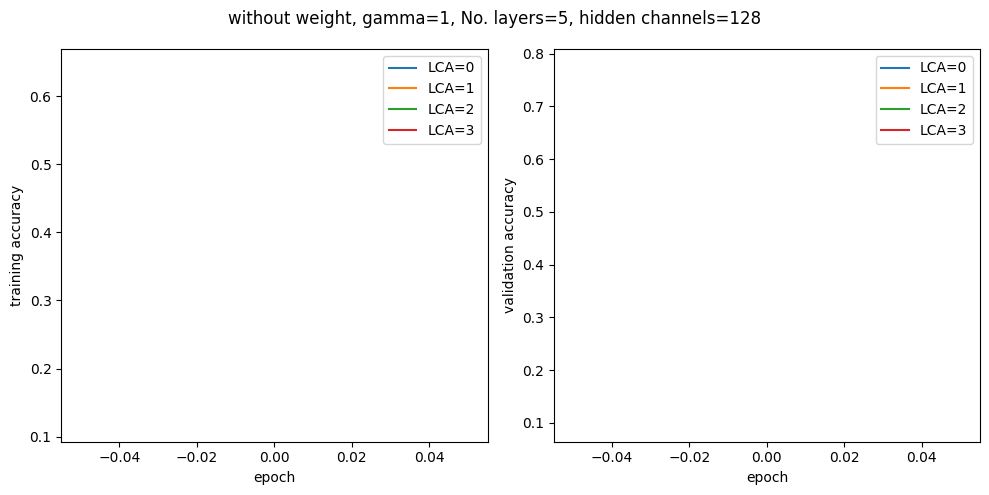

In [29]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle(plt_numlayer +', '+ plt_channel+', '+plt_mlp+', '+plt_step, fontsize=14)
# fig.suptitle("without weight, gamma=3")
fig.suptitle("without weight, gamma=1, " + plt_numlayer +', '+ plt_channel)

# plt.title("with weight, gamma=3")


axarr[0].plot(class1_acc_tr, label="LCA=0")
axarr[0].plot(class2_acc_tr, label="LCA=1")
axarr[0].plot(class3_acc_tr, label="LCA=2")
axarr[0].plot(class4_acc_tr, label="LCA=3")

axarr[0].set_xlabel('epoch')
axarr[0].set_ylabel('training accuracy')

axarr[0].legend()

axarr[1].plot(class1_acc_vl, label="LCA=0")
axarr[1].plot(class2_acc_vl, label="LCA=1")
axarr[1].plot(class3_acc_vl, label="LCA=2")
axarr[1].plot(class4_acc_vl, label="LCA=3")

axarr[1].set_xlabel('epoch')
axarr[1].set_ylabel('validation accuracy')

axarr[1].legend()

fig.tight_layout()
# fig.subplots_adjust(top=0.88)
plt.savefig("acc_LCAloss_BCE_pruning_from_epoch_30_new_4"+".png")


In [ ]:
torch.save(myModel.state_dict(), 'model_6block_32epochs_with_node_edge_weights.pth')